# Imports

Importação das bibliotecas e funções utilizadas

In [ ]:
import imageio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import hsv_to_rgb, rgb_to_hsv
from scipy import ndimage
import math
from skimage.transform import resize
import cv2

Importação das imagens da pessoa e do fundo. O conjunto de imagens é numerado de 1 a 3, determinando qual par de pessoa-fundo está sendo selecioando

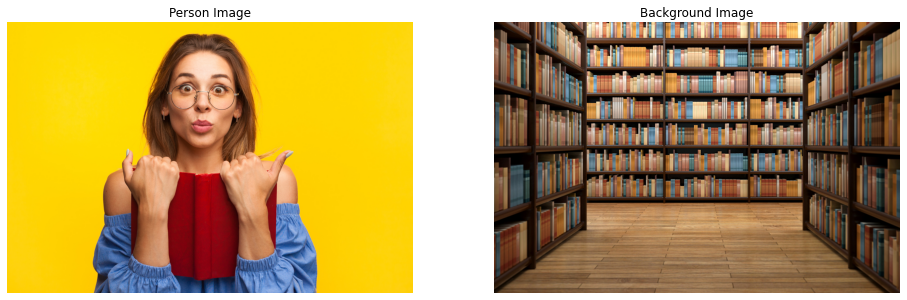

In [ ]:
n_test = 3
img = imageio.imread('images/image{}.png'.format(n_test))
bg = imageio.imread('images/bg{}.png'.format(n_test))


plt.figure(figsize=(16, 10))
plt.subplot(121); plt.imshow(img); plt.title('Person Image'); plt.gca().set_axis_off();
plt.subplot(122); plt.imshow(bg); plt.title('Background Image'); plt.gca().set_axis_off();
plt.show()

# Tornar imagem preta e branca

O primeiro passo, antes de detectar as bordas da pessoa, é transformar a imagem original RGB de 3 canais para apenas 1 canal (imagem em preto e branco) para isso ser feito, foi utilizada a técnica de luminance que faz uma média ponderada dos 3 canais de acordo com como são percebidos pela visão humana.

In [ ]:
def img_to_bw(img):
  img_bw = np.zeros(img.shape[:-1])
  img_bw = 0.299 * img[:,:,0] + 0.587 * img[:,:,1] + 0.114 * img[:,:,2]

  return img_bw

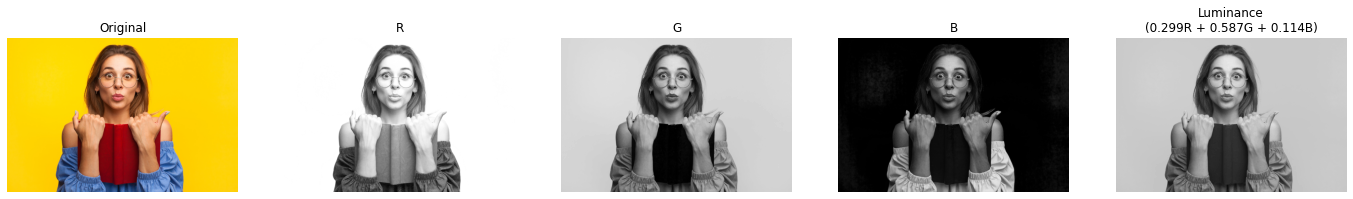

In [ ]:
img_bw = img_to_bw(img)

plt.figure(figsize=(24, 10))

plt.subplot(251); plt.imshow(img); plt.title('Original'); plt.gca().set_axis_off();
plt.subplot(252); plt.imshow(img[:,:,0], cmap='gray'); plt.title('R'); plt.gca().set_axis_off();
plt.subplot(253); plt.imshow(img[:,:,1], cmap='gray'); plt.title('G'); plt.gca().set_axis_off();
plt.subplot(254); plt.imshow(img[:,:,2], cmap='gray'); plt.title('B'); plt.gca().set_axis_off();
plt.subplot(255); plt.imshow(img_bw, cmap='gray'); plt.title('Luminance\n(0.299R + 0.587G + 0.114B)'); plt.gca().set_axis_off();

# Filtro LoG (Laplacian of Gaussian)

Foi aplicado um filtro LoG (gaussiano seguido de laplaciano) na imagem em preto em branco, para se detectar as bordas da imagem. Os valores negativos foram clipados para 0, para facilitar a visualização.

In [ ]:
def apply_log_filter_cv(img, n, sigma):
  img_gauss = cv2.GaussianBlur(img,(n, n), sigma)
  img_log = cv2.Laplacian(img_gauss, cv2.CV_64F)
  img_log[img_log < 0] = 0

  return img_log

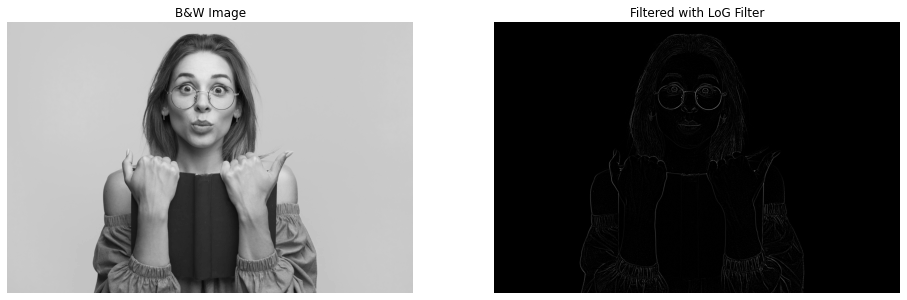

In [ ]:
img_log = apply_log_filter_cv(img_bw, n=9, sigma=2)

plt.figure(figsize=(16, 10))
plt.subplot(121); plt.imshow(img_bw, cmap='gray'); plt.title('B&W Image'); plt.gca().set_axis_off()
plt.subplot(122); plt.imshow(img_log, cmap='gray'); plt.title('Filtered with LoG Filter'); plt.gca().set_axis_off()

# Criação da máscara

## Identificando fundo

O primeiro passo para criar a máscara é criar, inicialmente, uma máscara mais grosseira, identificando que área aproximada é a correspondente ao background da imagem. Isso é feito percorrendo a imagem filtrada horizontalmente, em ambas as direções, até ser encontrado um valor acima de determinado limite de tolerância.

In [ ]:
def create_bg_mask(img, tolerance=0.5):
  mask = np.zeros(img.shape)

  xmax = img.shape[0]
  ymax = img.shape[1]

  i = 0
  j = 0

  #percorrer da esquerda pra direita
  while 1:
    if (img[i, j] < tolerance):
      mask[i, j] = 1
      if (j < ymax-1):
        j += 1
      else: 
        if (i < xmax-1):
          i += 1
          j = 0
        else:
          break
    elif (i < xmax-1): 
        i += 1
        j = 0
    else:
      break

  i = xmax-1
  j = ymax-1

  #percorrer da direita pra esquerda
  while 1:
    if (img[i, j] < tolerance):
      mask[i, j] = 1
      if (j > 0):
        j -= 1
      else: 
        if (i > 0):
          i -= 1
          j = ymax-1
        else:
          break
    elif (i > 0): 
        i -= 1
        j = ymax-1
    else:
      break
  
  return np.uint8(mask)


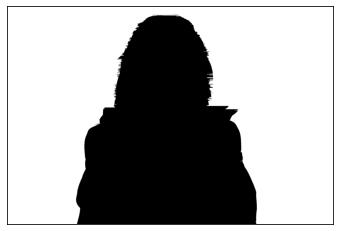

In [ ]:
bg_mask = create_bg_mask(img_log, tolerance=0.5)
plt.imshow(bg_mask, cmap='gray')
plt.tick_params(axis='both',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)
plt.show()

## Aprimorando a máscara com base na cor de fundo

A máscara criada é aplicada sob a imagem, e, com isso, pode se determinar qual a cor média do fundo. A partir do valor HSV dessa média, é adicionado e subtraído um certo valor de tolerância, para ser criado um range de cores a ser identificado como cor de fundo. Foram feitos alguns testes e se chegou ao valor [0.4, 0.35, 0.5] que obteve bons resultados em todos eles. Porém, é um parâmetro que pode ser ajustado de acordo com a imagem de entrada.

Com esse range de cores, é criada uma máscara com toda a região da imagem que tem essa cor.

In [ ]:
def create_hsv_mask(img, bg_mask, hsv_tol=[0.4, 0.35, 0.5]):
  img_hsv = rgb_to_hsv(img)

  bg_mean_hsv = np.array(cv2.mean(img_hsv, mask=bg_mask)[:-1])
  hsv_tol = bg_mean_hsv * np.array(hsv_tol)

  lower_hsv = np.clip(bg_mean_hsv - hsv_tol, [0, 0, 0], [1, 1, 255])
  upper_hsv = np.clip(bg_mean_hsv + hsv_tol, [0, 0, 0], [1, 1, 255])

  hsv_mask = cv2.inRange(img_hsv, lower_hsv, upper_hsv)

  return hsv_mask

In [ ]:
def apply_mask(img, mask, value=0):

  img = resize(img, mask.shape)
  img_masked = np.zeros(img.shape)

  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      if (mask[i, j] == value):
        img_masked[i, j] == 0
      else:
        img_masked[i, j] = img[i, j]

  return img_masked

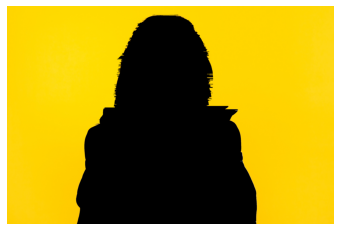

In [ ]:
original_bg_masked = apply_mask(img, bg_mask, 0)

plt.imshow(original_bg_masked)
plt.gca().set_axis_off()
plt.show()

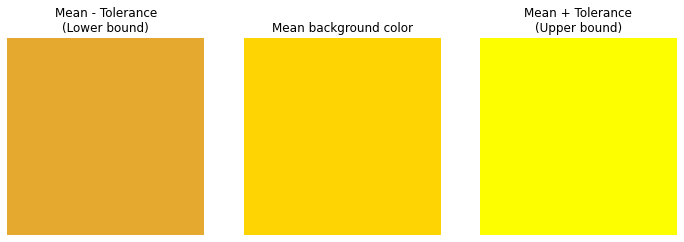

In [ ]:
img_hsv = rgb_to_hsv(img)

bg_mean_hsv = np.array(cv2.mean(img_hsv, mask=bg_mask)[:-1])
hsv_tol = bg_mean_hsv * np.array([0.2, 0.2, 0.1])

lower_hsv = np.clip(bg_mean_hsv - hsv_tol, [0, 0, 0], [1, 1, 255])
upper_hsv = np.clip(bg_mean_hsv + hsv_tol, [0, 0, 0], [1, 1, 255])

lower_square = np.full((10, 10, 3), hsv_to_rgb(lower_hsv), dtype=np.uint8) 
mean_square = np.full((10, 10, 3),  hsv_to_rgb(bg_mean_hsv), dtype=np.uint8) 
upper_square = np.full((10, 10, 3), hsv_to_rgb(upper_hsv), dtype=np.uint8)

plt.figure(figsize=(12, 8))

plt.subplot(131); plt.imshow(lower_square); plt.gca().set_axis_off(); plt.title('Mean - Tolerance\n(Lower bound)')
plt.subplot(132); plt.imshow(mean_square); plt.gca().set_axis_off(); plt.title('Mean background color')
plt.subplot(133); plt.imshow(upper_square); plt.gca().set_axis_off(); plt.title('Mean + Tolerance\n(Upper bound)')
plt.show()

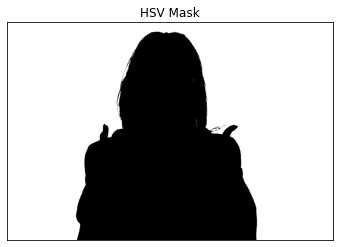

In [ ]:
hsv_mask = create_hsv_mask(img, bg_mask)

plt.imshow(hsv_mask, cmap='gray'); plt.title('HSV Mask');
plt.tick_params(axis='both',which='both', bottom=False, top=False, left=False, labelleft=False, labelbottom=False)

## Unindo as máscaras criadas

As duas máscaras criadas são unidas para gerar a máscara final. De forma geral, a máscara final é basicamente igual a última, mas elas podem diferir em caso de o fundo ter alguma região de cor muito distinta da média.

In [ ]:
def add_masks(mask1, mask2):
  mask = np.clip(mask1 - mask2, 0, 1)

  return mask

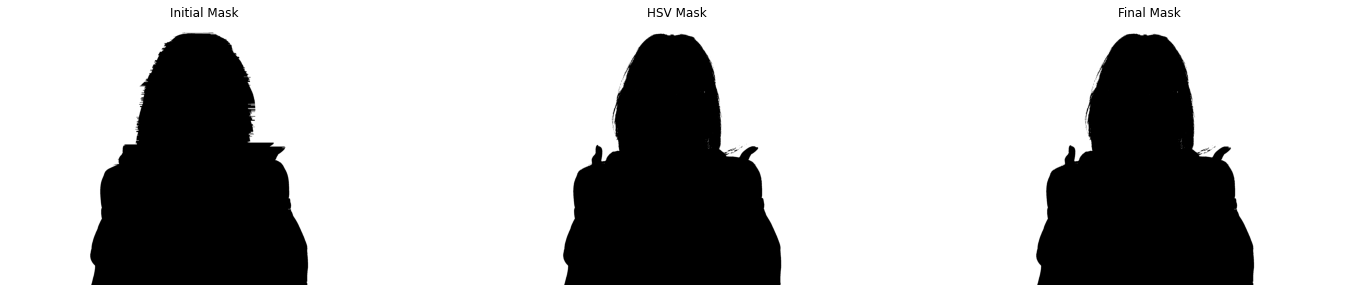

In [ ]:
mask = add_masks(bg_mask, hsv_mask)

plt.figure(figsize=(24, 8))
plt.subplot(131); plt.imshow(bg_mask, cmap='gray'); plt.title('Initial Mask'); plt.gca().set_axis_off()
plt.subplot(132); plt.imshow(hsv_mask, cmap='gray'); plt.title('HSV Mask'); plt.gca().set_axis_off()
plt.subplot(133); plt.imshow(mask, cmap='gray'); plt.title('Final Mask'); plt.gca().set_axis_off()

# Aplicando a máscara

A máscara encontrada é aplicada em ambas as imagens de entrada

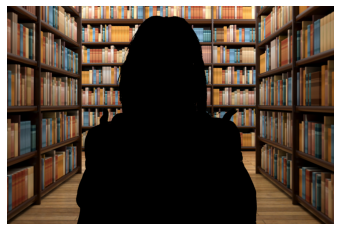

In [ ]:
bg_masked = apply_mask(bg, mask, 0)

plt.imshow(bg_masked, cmap='gray')
plt.gca().set_axis_off()
plt.show()

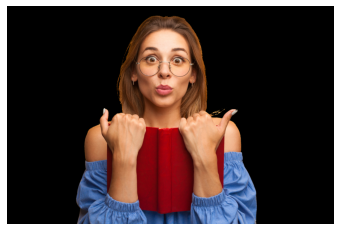

In [ ]:
img_masked = apply_mask(img, mask, 1)

plt.imshow(img_masked, cmap='gray')
plt.gca().set_axis_off()
plt.show()

# Resultado Final

Por mim, as imagens são unidas simplesmente com uma soma (pixel a pixel)

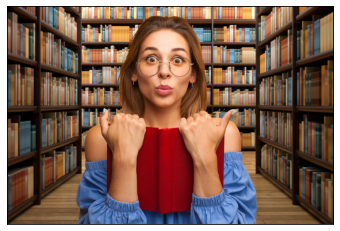

In [ ]:
img_final = img_masked + bg_masked
plt.imshow(img_final, cmap='gray')
plt.gca().set_axis_off()
plt.show()

# Processamento completo

Foi criada uma função que une todo o processo

In [ ]:
def add_background(img, bg, mask_tol=0.5, n=9, sigma=2, hsv_tol=[0.4, 0.35, 0.5]):
  #TODO: fix LoG filter
  img_bw = img_to_bw(img)
  img_log = apply_log_filter_cv(img_bw, n, sigma)

  bg_mask = create_bg_mask(img_log, mask_tol)
  hsv_mask = create_hsv_mask(img, bg_mask, hsv_tol)
  mask = add_masks(bg_mask, hsv_mask)

  img_masked = apply_mask(img, mask, 1)
  bg_masked = apply_mask(bg, mask, 0)

  img_final = img_masked + bg_masked

  plt.figure(figsize=(24, 12))
  plt.subplot(131); plt.imshow(img, cmap='gray'); plt.gca().set_axis_off(); plt.title('Person Image')
  plt.subplot(132); plt.imshow(bg, cmap='gray'); plt.gca().set_axis_off(); plt.title('Background Image')
  plt.subplot(133); plt.imshow(img_final, cmap='gray'); plt.gca().set_axis_off(); plt.title('Final Image')

  plt.show()


# Exemplos de resultados

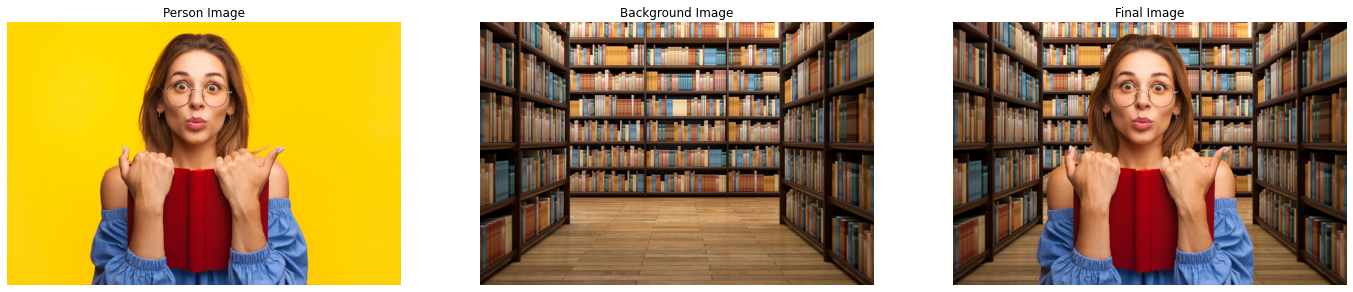

In [ ]:
n_test = 3
img = imageio.imread('images/image{}.png'.format(n_test))
bg = imageio.imread('images/bg{}.png'.format(n_test))

add_background(img, bg)

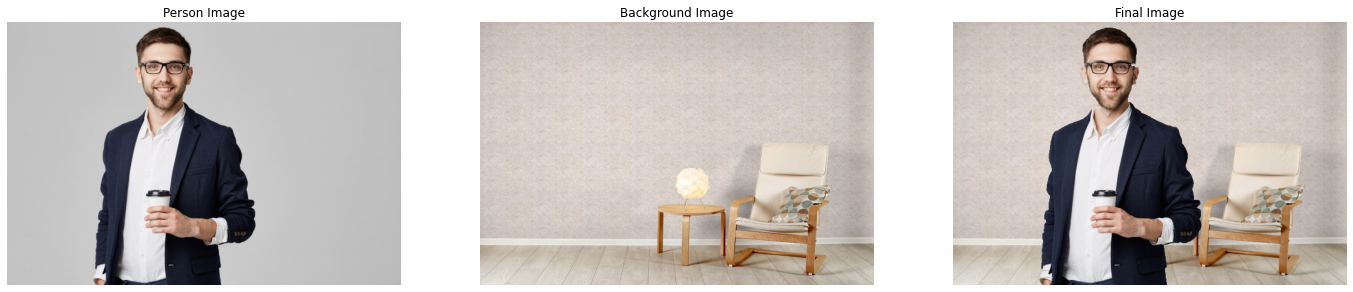

In [ ]:
n_test = 1
img = imageio.imread('images/image{}.png'.format(n_test))
bg = imageio.imread('images/bg{}.png'.format(n_test))

add_background(img, bg)

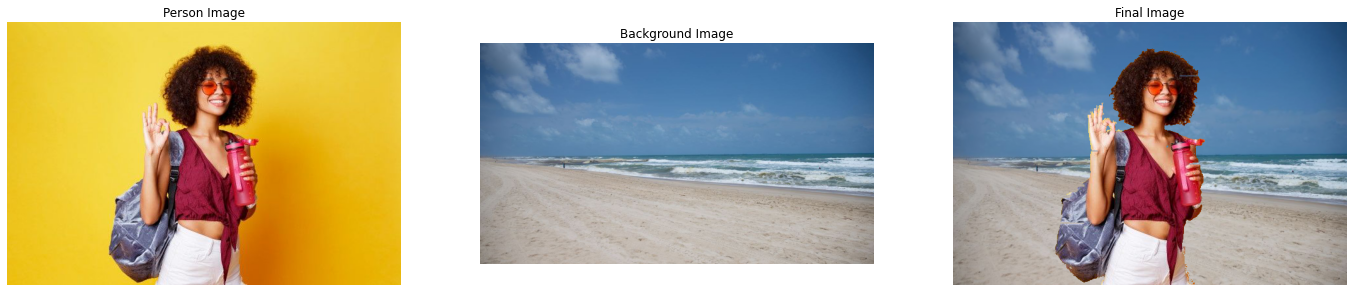

In [ ]:
n_test = 2
img = imageio.imread('images/image{}.png'.format(n_test))
bg = imageio.imread('images/bg{}.png'.format(n_test))

add_background(img, bg)